## Data Wrangling And Pre-Processing

Data wrangling is the process of removing errors and combining complex dataset to make them more accessible and easier to analyze. Before analyzing the dataset, we have to do this by the objective we want.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# load train data set and label
df_tr = pd.read_csv('./training_set_values.csv', index_col=0)
df_tr_lable = pd.read_csv('./training_set_lable.csv', index_col=0)
# load testing data set
df_test = pd.read_csv('./test_set_values.csv', index_col=0)

##### Step 1:
Drop useless columns to make dataset lighter and easier. 

1.1: `num_private`: This column does not have a specific description, and the field is almost filled with `0`, the column should be dropped.

In [2]:
df_tr['num_private'].value_counts()

0       58643
6          81
1          73
5          46
8          46
        ...  
42          1
23          1
136         1
698         1
1402        1
Name: num_private, Length: 65, dtype: int64

1.2: The following groups of column have similar meaning, it could be simplified and remain only one column.

(`funder`, `installer`),

(`extraction_type`, `extraction_type_group`, `extraction_type_class`),

(`scheme_management`, `management`)

(`payment`, `payment_type`),

(`water_quality`, `quality_group`),

(`quantity`, `quantity_group`),

(`source`, `source_type`),

(`waterpoint_type`, `waterpoint_type_group`),

1.3: `region_code`, `district_code`, `region`, `wpt_name`, `lga`, `ward` are all geographic related info that only indicates area name, it seems do not have any impact to the model and result.

In [3]:
def drop_columns(df):
    delete_columns = [
        'num_private', 'installer', 'extraction_type_group','extraction_type_class',
        'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type',
        'region_code', 'district_code', 'region', 'wpt_name', 'lga', 'ward'
    ]
    df.drop(delete_columns, axis=1, inplace=True)

drop_columns(df_tr)

##### Step 2:

Some columns may have a large number of enum items. It could take the enumeration value with the highest frequency, and replace the rest of `other`.

In [4]:
def top5_values(df, column_name):
    return df[column_name].value_counts().nlargest(5).index.tolist()

def divede(row, ls, str):
    return row[str] if row[str] in ls else 'other'

def classify(df):
    column_list = ['funder', 'scheme_management']
    for i in column_list:
        df[i] = df.apply(divede, args=(top5_values(df, i), i), axis=1)

classify(df_tr)

##### Step 3:
Quick went through the dataset, write a script to check out all NaN value.

In [5]:
def check_invalid(df):
    rows_num = df.shape[0]
    for col in df.columns:
        col_isna_num = df[col].isna().sum()
        if col_isna_num > 0:
            print('`{}` has {} Nan value, portion: {:.2%}'.format(col, col_isna_num, col_isna_num/rows_num))

check_invalid(df_tr)

`subvillage` has 371 Nan value, portion: 0.62%
`public_meeting` has 3334 Nan value, portion: 5.61%
`scheme_name` has 28166 Nan value, portion: 47.42%
`permit` has 3056 Nan value, portion: 5.14%


##### Step 4:
Dealing with the missing values, Fill the missing values as `unknown`.

In [6]:
def handle_missing(df):
    df['subvillage'].fillna('unknown', inplace=True)
    df['public_meeting'].fillna('unknown', inplace=True)
    df['scheme_name'].fillna('unknown', inplace=True)
    df['permit'].fillna('unknown', inplace=True)

handle_missing(df_tr)

##### Step 5:
Drop duplicate rows in the dataset. As the result, the dataset do not contain duplicate rows.

In [7]:
def drop_duplicate(df):
    print('number of rows before deduplicate: {} rows'.format(df.shape[0]))
    df.drop_duplicates(inplace=True)
    print('number of rows after deduplicate: {} rows'.format(df.shape[0]))
    
drop_duplicate(df_tr)

number of rows before deduplicate: 59400 rows
number of rows after deduplicate: 59229 rows


##### Step 6:
Combine the lable to the traing set.

In [8]:
def merge_label(df, df_lable):
    for i, row in df.iterrows():
        df.loc[i, 'status'] = df_lable.loc[i]['status_group']
    df.info()

merge_label(df_tr, df_tr_lable)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59229 entries, 69572 to 26348
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59229 non-null  float64
 1   date_recorded          59229 non-null  object 
 2   funder                 59229 non-null  object 
 3   gps_height             59229 non-null  int64  
 4   longitude              59229 non-null  float64
 5   latitude               59229 non-null  float64
 6   basin                  59229 non-null  object 
 7   subvillage             59229 non-null  object 
 8   population             59229 non-null  int64  
 9   public_meeting         59229 non-null  object 
 10  recorded_by            59229 non-null  object 
 11  scheme_management      59229 non-null  object 
 12  scheme_name            59229 non-null  object 
 13  permit                 59229 non-null  object 
 14  construction_year      59229 non-null  int64  
 15

##### Step 7:
The test data set needs to do the same process as training date set.

In [9]:
drop_columns(df_test)
handle_missing(df_test)
drop_duplicate(df_test)
classify(df_test)

number of rows before deduplicate: 14850 rows
number of rows after deduplicate: 14841 rows


## Data statistical description

The histogram below displays the distribution of water points across different statuses and influencing factors. By analyzing the data presented, it is possible to determine the impact of various factors on the status of water points.

In [12]:
def wrap_labels(ax, width, break_long_words=False):
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(range(len(labels)))
    labels = [textwrap.fill(label, width=width, break_long_words=break_long_words) for label in labels]
    ax.set_xticklabels(labels)

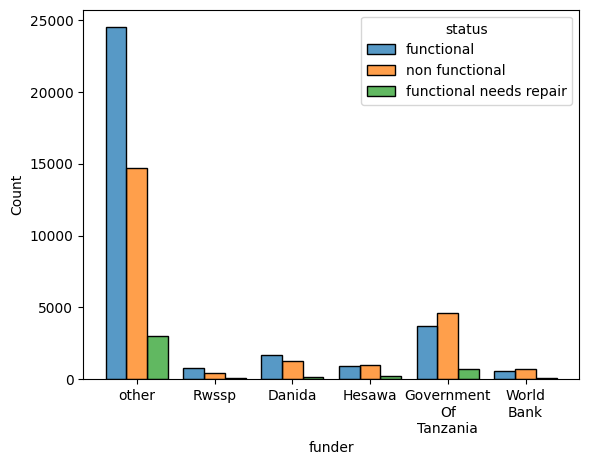

In [13]:
fig, ax = plt.subplots()
sns.histplot(data=df_tr, x='funder', hue='status', multiple='dodge', shrink=.8, ax=ax)
wrap_labels(ax, 8)
plt.show()

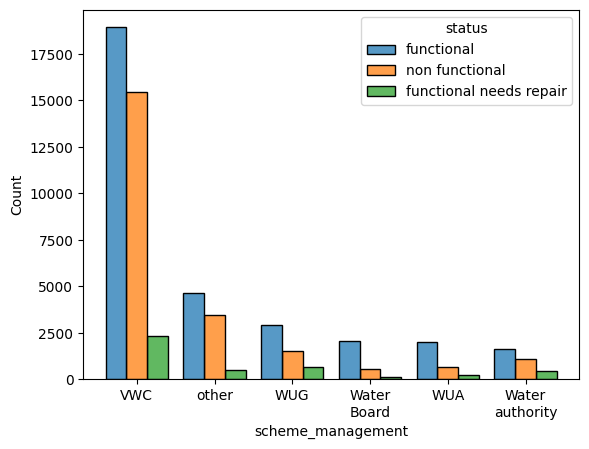

In [238]:
fig, ax = plt.subplots()
sns.histplot(data=df_tr, x='scheme_management', hue='status', multiple='dodge', shrink=.8)
wrap_labels(ax, 8)
plt.show()

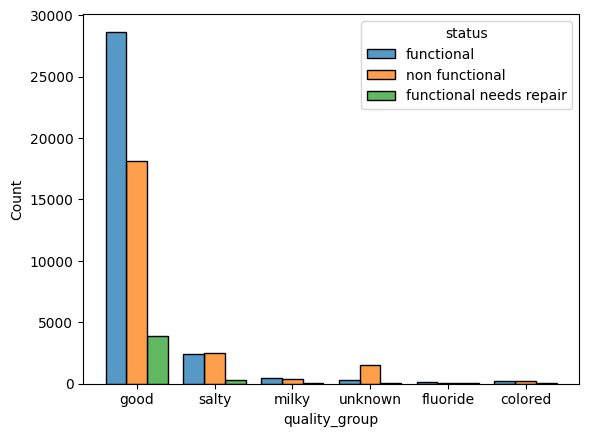

In [239]:
sns.histplot(data=df_tr, x='quality_group', hue='status', multiple='dodge', shrink=.8)
plt.show()

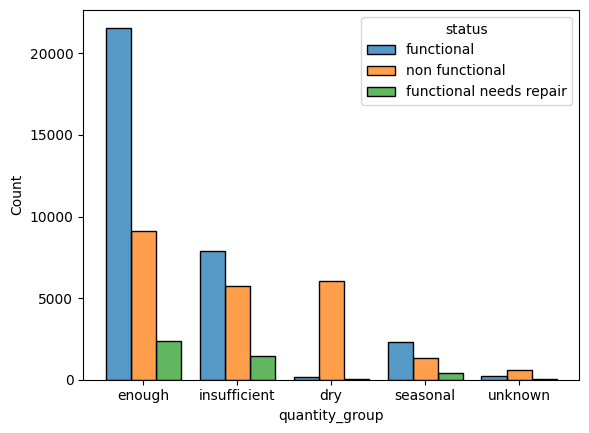

In [240]:
sns.histplot(data=df_tr, x='quantity_group', hue='status', multiple='dodge', shrink=.8)
plt.show()

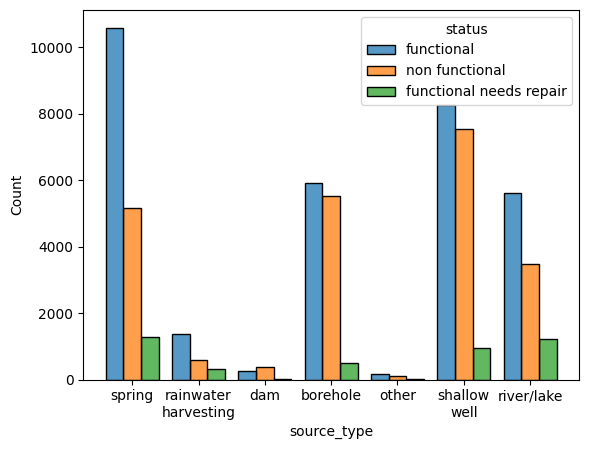

In [241]:
fig, ax = plt.subplots()
sns.histplot(data=df_tr, x='source_type', hue='status', multiple='dodge', shrink=.8)
wrap_labels(ax, 8)
plt.show()